In [3]:
import sys
import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../core/python')

from commons import inc_inference_with_model, inc_inference, show_heatmap
from imagenet_classes import class_names
from vgg16 import VGG16
from resnet18 import ResNet18
from inception3 import Inception3

In [4]:
image_file_path = "../images/input/imagenet/dog.jpg"

In [3]:
#vgg_model = VGG16(beta=1.0, gpu=True, n_labels=1000).eval()
#resnet_model = ResNet18(beta=1.0, gpu=True, n_labels=1000).eval()
#inception size fix issue 
#inception_model = Inception3(beta=1.0, gpu=True, n_labels=1000).eval()

/usr/local/lib/python2.7/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
def calculateX(xsize, ysize, patch, stride):
    return (xsize - patch) * (ysize - patch) * 1.0 / stride / stride

'''
    choose a list of different sizes, using linear regression to make the approach
    in terms of the patch_size as well as stride_size, we choose use random choice
'''

xsize_list = [224, 112, 168, 112, 168, 56, 56]
ysize_list = [224, 224, 224, 112, 112, 112, 56]

patch_size = [16, 8, 4, 2, 1]
stride_size = [16, 8, 4, 2, 1]

len_list = len(xsize_list)

vgg_paralist = []
vgg_timelist = []
resnet_paralist = []
resnet_timelist = []

'''
    there will be illegal memory issue for running the same model multiple times?
'''

for i in range(len_list):
    for j in patch_size:
        for k in stride_size:
            
            x = calculateX(xsize_list[i], ysize_list[i], j, k)
            start_time = time.time()
            _,_,_ = inc_inference(VGG16, image_file_path, patch_size=j, stride=k, x_size=xsize_list[i], y_size=ysize_list[i], gpu=True)
            #_,_,_ = inc_inference_with_model(vgg_model, image_file_path, patch_size=patch_sample, stride=stride_sample, x_size=xsize_list[i], y_size=ysize_list[i], gpu=True)

            end_time = time.time()
            vgg_paralist.append(x)
            vgg_timelist.append(end_time - start_time)

            start_time = time.time()
            _,_,_ = inc_inference(ResNet18, image_file_path, patch_size=j, stride=k, x_size=xsize_list[i], y_size=ysize_list[i], gpu=True)
            #_,_,_ = inc_inference_with_model(resnet_model, image_file_path, patch_size=patch_sample, stride=stride_sample, x_size=xsize_list[i], y_size=ysize_list[i], gpu=True)

            end_time = time.time()
            resnet_paralist.append(x)
            resnet_timelist.append(end_time - start_time)


/usr/local/lib/python2.7/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [6]:
'''
    we have to minimize the ||Ax - b|| --> need to find the optimal approach 
    Calculate the slope and intercept for a given list for parameters
    on the time as well as constant, we'll use closed-form linear regression to derive the slope,
    intercept for vgg, resnet. 
    
    vgg_paralist 1 * 175 appends all ones --> to make it A 2 * 175
    vgg_timelist 1 * 175
'''
llen = len(vgg_paralist)

vgg_para = np.asarray(vgg_paralist).reshape((llen,1))
vgg_time = np.asarray(vgg_timelist).reshape((llen,1))
resnet_para = np.asarray(resnet_paralist).reshape((llen,1))
resnet_time = np.asarray(resnet_timelist).reshape((llen,1))
ones = np.ones((llen,1))


In [7]:
A_vgg = np.hstack((vgg_para, ones))
A_resnet = np.hstack((resnet_para, ones))

In [8]:
X_vgg = np.dot(np.dot(np.linalg.inv(np.dot(A_vgg.T, A_vgg)),A_vgg.T), vgg_time)
X_resnet = np.dot(np.dot(np.linalg.inv(np.dot(A_resnet.T, A_resnet)),A_resnet.T), resnet_time)

In [10]:
# def abline(slope, intercept, para, time):
#     axes = plt.gca()
#     x_vals = np.arange(1,20000,1)
#     y_vals = intercept + slope * x_vals
#     plt.plot(x_vals, y_vals, '--')
#     plt.plot(para, time, 'ro')

In [13]:
def abline(slope, intercept, para, time):
    #plot a line
    fig = plt.figure()
    axes = plt.gca()
    x_vals = np.arange(1,40000,1)
    y_vals = intercept + slope * x_vals
    ax = fig.add_axes(axes)
    ax.plot(x_vals, y_vals, '--')
    ax.plot(para, time, 'ro')
    ax.set_title('axes title')
    ax.set_xlabel('number of computations')
    ax.set_ylabel('estimated time(s)')
    return fig

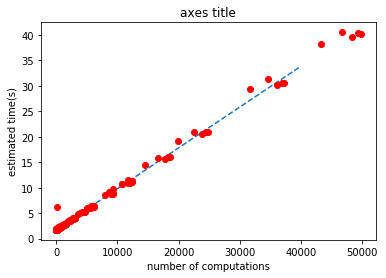

In [15]:
vgg_fig = abline(X_vgg[0][0], X_vgg[1][0], vgg_paralist, vgg_timelist)
vgg_fig.savefig("vgg_time_approx.jpg")

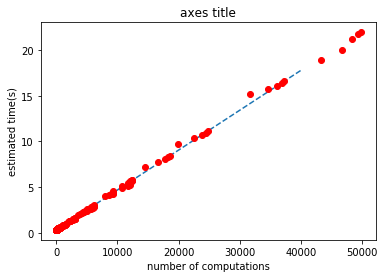

In [16]:
resnet_fig = abline(X_resnet[0][0], X_resnet[1][0], resnet_paralist, resnet_timelist)
resnet_fig.savefig("resnet_time_approx.jpg")

In [17]:
data = {}
data['vgg16'] = []
data['resnet18'] = []

data['vgg16'].append({
    'slope': X_vgg[0][0],
    'intercept': X_vgg[1][0],
})    

data['resnet18'].append({
    'slope': X_resnet[0][0],
    'intercept': X_resnet[1][0],
})    

with open('updated-time-estimation.txt', 'w') as outfile:
    json.dump(data, outfile)

In [6]:
'''
    In this auto-configuration, we're targeting on find the intercept & slope for each model based on current GPU
    in order to repeat the real scene of the entire time from setting up a model from scratch 
    parameters affecting the running time are: stride, patch, model, x_size , y_size
    However, in one GPU, number of calcualation for a batch size is certain, therefore, we can estimate time to compute 
    depends on the these input, basically number of computations is on proportional to 
    number of computations = (x_size - patch) * (y_size - patch) / stride / stride
'''

'''
def makeEstimation(model_class, image_file_path):
    slope, intercept = get_parameters(model_class, image_file_path)
    return slope, intercept
    
    
def get_parameters(model_class, image_file_path):
	print('start configuration')
	begin_time1 = time.time()
	_, _, _ = inc_inference(model_class, image_file_path, patch_size=16, stride=8, beta=1.0, x0=0, y0=0, x_size=224, y_size=224, gpu=True, c=0.0)
	end_time1 = time.time()
	patch, stride = 16, 8
	y1 = end_time1 - begin_time1
	x1 = (224 - patch) * (224 - patch) * 1.0 / stride / stride
	print('1 done')
	begin_time2 = time.time()
	_, _, _ = inc_inference(model_class, image_file_path, patch_size=16, stride=2, beta=1.0, x0=0, y0=0, x_size=100, y_size=100, gpu=True, c=0.0)
	end_time2 = time.time()
	patch, stride = 16, 2
	print('2 done')	
	y2 = end_time2 - begin_time2
	x2 = (100 - patch) * (100 - patch) * 1.0 / stride / stride
	alpha = (y2 - y1) / (x2 - x1)
	beta = y1 - alpha * x1
	return alpha, beta
'''

In [4]:
# begin_time = time.time()
# _,_,_ = inc_inference_with_model(vgg_model, image_file_path, patch_size=4, stride=4, beta=1.0, x0=0, y0=0, image_size=224, x_size=224,
#                       y_size=224, version='v1', gpu=True, c=0.0)
# end_time = time.time()
# time_elapsed = end_time - begin_time

In [5]:
'''
    In this auto-configuration, we're targeting on find the intercept & slope for each model based on current GPU
    we'll plug in 2 samples to calculate the slope & intercept and save them into json file. 
    In this way, we can save lots of time in calculating time-estimation.
'''

# def makeEstimation(model, image_file_path):
#     slope, intercept = auto_configure(model, image_file_path)
#     return slope, intercept
    
    
# def auto_configure(model, image_file_path):
# 	print('start configuration')
# 	begin_time1 = time.time()
# 	_, _, _ = inc_inference_with_model(model, image_file_path, patch_size=16, stride=8, beta=1.0, x0=0, y0=0, x_size=224, y_size=224, gpu=True, c=0.0)
# 	end_time1 = time.time()
# 	patch, stride = 16, 8
# 	y1 = end_time1 - begin_time1
# 	x1 = (224 - patch) * (224 - patch) * 1.0 / stride / stride
# 	print('1 done')
# 	begin_time2 = time.time()
# 	_, _, _ = inc_inference_with_model(model, image_file_path, patch_size=16, stride=2, beta=1.0, x0=0, y0=0, x_size=100, y_size=100, gpu=True, c=0.0)
# 	end_time2 = time.time()
# 	patch, stride = 16, 2
# 	print('2 done')	
# 	y2 = end_time2 - begin_time2
# 	x2 = (100 - patch) * (100 - patch) * 1.0 / stride / stride
# 	alpha = (y2 - y1) / (x2 - x1)
# 	beta = y1 - alpha * x1
# 	return alpha, beta
 

In [ ]:
'''
start the experimeng with vgg16
iterate all time-possibilities of vgg16
store all the patch,stride,height,width possibilities into .json 
as the backend for later estimate time cost
of running Krypton
'''
# patch_dict = [1,2,4,8,16]
# stride_dict = [1,2,4,8,16]

# data = {}
# data['vgg16'] = []

# for pt in patch_dict:
#     print('pt: ' + str(pt))
#     for st in stride_dict:
#         print('st: ' + str(st))
#         for x in range(1,225):
#             print('x: ' + str(x))
#             for y in range(1,225):
#                 #print('y: ' + str(y))
#                 begin_time = time.time()
#                 _,_,_ = inc_inference_with_model(vgg_model, image_file_path, patch_size=pt, stride=st, beta=1.0, x0=0, y0=0, image_size=224, x_size=x,
#                                       y_size=y, version='v1', gpu=True, c=0.0)
#                 end_time = time.time()
#                 time_elapsed = end_time - begin_time
#                 data['vgg16'].append({
#                     'patch': pt,
#                     'stride': st,
#                     'width': x,
#                     'height': y,
#                     'time': time_elapsed
#                 })
        
        
# with open('time-estimation.txt', 'w') as outfile:
#     json.dump(data, outfile)

pt: 1
st: 1
x: 1
x: 2
x: 3
x: 4
x: 5
x: 6
x: 7
x: 8
